# A/A/B тест замены шрифтов на сайте.

## Введение

Мы работаем в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.

Изучим воронку продаж. Узнаем, как пользователи доходят до покупки.  
После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно.  
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Импортируем библиотеки, которые будут использоваться в проекте.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
from matplotlib import pyplot as plt

## Откроем файл с данными и изучим общую информацию

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t')
data.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Описание данных: 
  
Каждая запись в логе — это действие пользователя, или событие.  
- EventName — название события;  
- DeviceIDHash — уникальный идентификатор пользователя;  
- EventTimestamp — время события;  
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

## Подготовим данные

### Заменим названия столбцов на удобные для нас.

In [3]:
data.columns = ['event_name', 'device_id', 'event_timestamp', 'exp_id']

- event_name — название события;  
- device_id — уникальный идентификатор пользователя;  
- event_timestamp — время события;  
- exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

### Проверим пропуски и типы данных.

In [4]:
data.isna().sum()

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

В данных нет пропусков.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id        244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Приведём время событие в формат datetime.

In [6]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s')
data.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


Проверим на наличие дубликатов.

In [7]:
print('Дубликатов в таблице', data.duplicated().sum())
data = data.drop_duplicates()

Дубликатов в таблице 413


В данных нет пропусков, удалили 413 дубликатов, данные в столбце с временем события привели в формат datetime.

## Изучим и проверим данные

In [8]:
print('Всего в логе', data['event_timestamp'].count(), 'событий')

Всего в логе 243713 событий


In [9]:
print(f"Всего пользователей в логе: {data['device_id'].nunique()}")

Всего пользователей в логе: 7551


In [10]:
print(f"В среднем на пользователя приходится {data.groupby('device_id').agg({'event_timestamp':'count'}).mean()['event_timestamp']} событий")

В среднем на пользователя приходится 32.27559263673685 событий


Посмотрим на гистограмме за какой период у нас сколько пользователей.

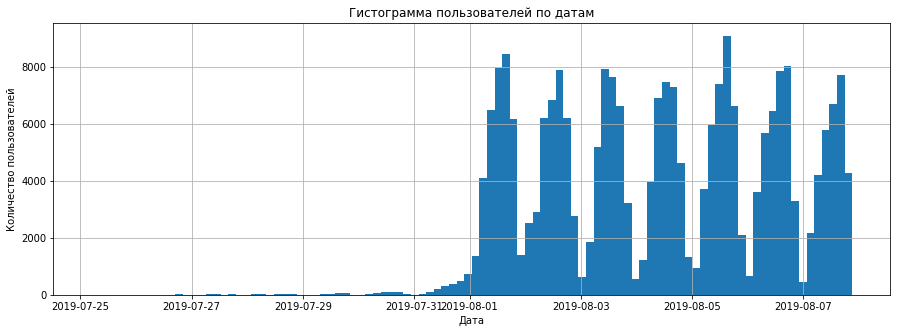

In [11]:
plt.title('Гистограмма пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
data['event_timestamp'].hist(figsize=(15,5), bins=100);

Увеличим середину гистограммы.

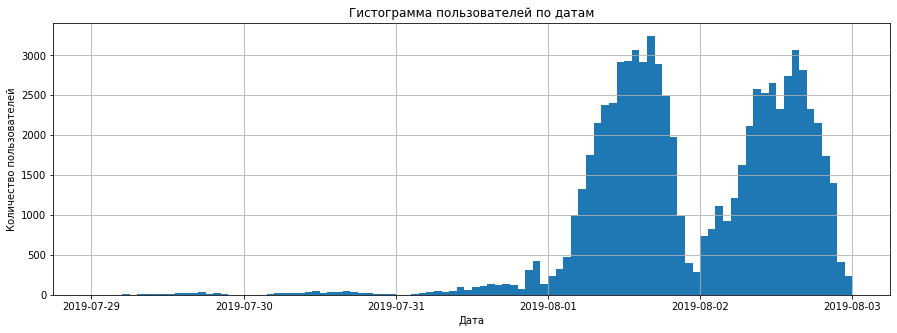

In [12]:
plt.title('Гистограмма пользователей по датам')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
data['event_timestamp'].hist(figsize=(15,5), bins=100, range=('2019-07-29', '2019-08-03'));

Видим что у нас данные начиная с первого августя, а всё что до этого видимо попало в данные по ошибке. Удалим их.

In [13]:
print('Мы удалили ', round((data.query("event_timestamp < '2019-08-01'")['event_timestamp'].count() / data['event_timestamp'].count()) * 100, 2),'% событий')

data = data.query("event_timestamp >= '2019-08-01'")
print(f"Всего осталось событий в логе: {data['event_timestamp'].count()}")
print(f"Всего осталось пользователей в логе: {data['device_id'].nunique()}")

Мы удалили  1.16 % событий
Всего осталось событий в логе: 240887
Всего осталось пользователей в логе: 7534


In [14]:
print("Итого у нас данные с")
print(data['event_timestamp'].min().date())
print("по")
print(data['event_timestamp'].max().date())

Итого у нас данные с
2019-08-01
по
2019-08-07


Посмотрим из всех ли групп A/A/B теста у нас есть пользователи.

In [15]:
data.groupby('exp_id').agg({'device_id':'nunique'})

,device_id
exp_id,
246,2484
247,2513
248,2537


Пользователей во всех группах примерно поровну.

Итого мы выяснили что у нас данные за одну неделю с 1-го по 7-е августа 2019-го года. Пользователей в каждой группе примерно поровну.

## Изучим воронку событий

### Посмотрим, какие события есть в логах и как часто они встречаются. Отсортируем события по частоте.

In [16]:
data.groupby('event_name').agg({'event_timestamp':'count'}).sort_values(by='event_timestamp', ascending=False)

,event_timestamp
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Чаще всего смотрят главный экран, почти в 3 раза реже экран с предложениями, чуть реже CartScreen, ещё чуть реже окно оплаты и почти не смотрят обучение.

### Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [17]:
events_users = data.groupby('event_name').agg({'device_id':'nunique'}).sort_values(by='device_id', ascending=False)
events_users['part'] = events_users['device_id'] / data['device_id'].nunique()
events_users

,device_id,part
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


По числу пользователей события распределились в том же порядке что и по общей частоте.

### Расчёт воронки.

Скорее всего пользователи сначала попадают на MainScreenAppear, затем переходят на OffersScreenAppear, затем CartScreenAppear и в итоге на PaymentScreenSuccessful. Страница Tutorial по всей видимости не обязательная и в воронке её можно не учитывать.  
  
Расчитаем какая доля пользователей доходит от предыдущего этама до следующего, запишем долю в столбец funnel.

In [18]:
events_users['funnel'] = events_users.apply(lambda row: row['device_id'] / events_users.query("device_id>@row['device_id']")['device_id'].min(), axis=1)
events_users = events_users.fillna(100).query("event_name!='Tutorial'")
events_users

,device_id,part,funnel
event_name,,,
MainScreenAppear,7419,0.984736,100.000000
OffersScreenAppear,4593,0.609636,0.619086
CartScreenAppear,3734,0.495620,0.812976
PaymentScreenSuccessful,3539,0.469737,0.947777


In [19]:
payment_users = data.query("event_name=='PaymentScreenSuccessful'")['device_id'].nunique()
main_screen_users = data.query("event_name=='MainScreenAppear'")['device_id'].nunique()

print(f"Всего от главной страницы и до окончания оплаты проходит {payment_users / main_screen_users:.1%} пользователей")

Всего от главной страницы и до окончания оплаты проходит 47.7% пользователей


Видим что с главной страницы на страницу с предложениями переходят только 61,9% пользователей, здесь теряется больше всего пользователей.

## Изучим результаты эксперимента.

### Убедимся что пропорции в группах A/A не различаются.

Сначала убедимся что нет пользователей, попавших сразу в несколько групп.

In [20]:
print('Пользователей, попавших сразу в несколько групп: ',data.groupby('device_id').agg({'exp_id':'nunique'}).query("exp_id>1").count()[0])

Пользователей, попавших сразу в несколько групп:  0


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.  
  
Сформулируем гипотезы:  
- H0 - доли уникальных посетителей, побывавших на этапе воронки, одинаковы.
- H1 - между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.
  
Порог статистической значимости возьмём 5%. Не смотря на то что у нас три группы, мы сравниваем только две выборки: старый шрифт и новый, поэтому делать поправку значимости на множественное сравнение не нужно.
  
Для начала создадим функцию pvalue_check для проверки статистической значимости.

In [21]:
def pvalue_check(successes, trials, alpha):    

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    print('разница в группах:', difference)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        ) 

Проверим разницу в контрольных A/A группах по посещению главной страницы.

In [22]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='MainScreenAppear'")['device_id'].nunique(), data.query("exp_id==247 & event_name=='MainScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==247")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.7570597232046099
разница в группах: 0.0010358374776444634
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу в контрольных A/A группах по переходам на страницу с предложениями.

In [23]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='OffersScreenAppear'")['device_id'].nunique(), data.query("exp_id==247 & event_name=='OffersScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==247")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.2480954578522181
разница в группах: 0.015918191587320774
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу в контрольных A/A группах по переходам на страницу CartScreen.

In [24]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='CartScreenAppear'")['device_id'].nunique(), data.query("exp_id==247 & event_name=='CartScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==247")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.22883372237997213
разница в группах: 0.01702355480967571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу в контрольных A/A группах по переходам на страницу с успешной оплатой платежа.

In [25]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique(), data.query("exp_id==247 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==247")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.11456679313141849
разница в группах: 0.022287967304317036
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В контрольных A/A группах нет разницы в пропорциях, значит можно приступать к расчёту итогов A/A/B теста.

### Сравнение пропорций в группе B с первой контрольной группой.

Проверим разницу по посещениям главной страницы между группами 246 и 248.

In [26]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='MainScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='MainScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.2949721933554552
разница в группах: 0.0036557182364452823
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с предложениями между группами 246 и 248.

In [27]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='OffersScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='OffersScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.20836205402738917
разница в группах: 0.01730428308378984
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу CartScreen между группами 246 и 248.

In [28]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='CartScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='CartScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.07842923237520116
разница в группах: 0.024837239769288977
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с успешной оплатой платежа между группами 246 и 248.

In [29]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==246 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])
pvalue_check(successes, trials, alpha)

p-значение:  0.2122553275697796
разница в группах: 0.017581342031651348
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В группах 246 и 248 нет разницы в пропорциях.

### Сравнение пропорций в группе B со второй контрольной группой.

Проверим разницу по посещениям главной страницы между группами 247 и 248.

In [30]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==247 & event_name=='MainScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='MainScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.4587053616621515
разница в группах: 0.002619880758800819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с предложениями между группами 247 и 248.

In [31]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==247 & event_name=='OffersScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='OffersScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.9197817830592261
разница в группах: 0.0013860914964690663
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу CartScreen между группами 247 и 248.

In [32]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==247 & event_name=='CartScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='CartScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.5786197879539783
разница в группах: 0.007813684959613265
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с успешной оплатой платежа между группами 247 и 248.

In [33]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("exp_id==247 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])
pvalue_check(successes, trials, alpha)

p-значение:  0.7373415053803964
разница в группах: -0.004706625272665688
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В группах 246 и 248 так же нет разницы в пропорциях.

### Сравнение пропорций в группе B с обеими контрольными группами вместе взятыми.

Проверим разницу по посещениям главной страницы.

In [34]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("(exp_id==246 | exp_id==247) & event_name=='MainScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='MainScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246 | exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.29424526837179577
разница в группах: 0.0031347937654985225
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с предложениями.

In [35]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("(exp_id==246 | exp_id==247) & event_name=='OffersScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='OffersScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246 | exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.43425549655188256
разница в группах: 0.009298996820244265
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу CartScreen.

In [36]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("(exp_id==246 | exp_id==247) & event_name=='CartScreenAppear'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='CartScreenAppear'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246 | exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])

pvalue_check(successes, trials, alpha)

p-значение:  0.18175875284404386
разница в группах: 0.01627606441673446
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим разницу по переходам на страницу с успешной оплатой платежа.

In [37]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([data.query("(exp_id==246 | exp_id==247) & event_name=='PaymentScreenSuccessful'")['device_id'].nunique(), data.query("exp_id==248 & event_name=='PaymentScreenSuccessful'")['device_id'].nunique()])
trials = np.array([data.query("exp_id==246 | exp_id==247")['device_id'].nunique(), data.query("exp_id==248")['device_id'].nunique()])
pvalue_check(successes, trials, alpha)

p-значение:  0.6004294282308704
разница в группах: 0.006372684469964585
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении пропорций в группе B с пропорциями суммарно в обеих контрольных группах, статистически значимой разницы так же выявлено не было.

### Итоги A/A/B теста.

Всего мы провели 16 проверок статистических гипотез. 4 из них сравнивали контрольные группы, и 12 контрольные группы с группой B. Во всех тестах между пропорциями в группах не выявлено статистически значимой разницы.  
  
Если бы мы увеличили порог значимости с 5% до 10%, то тест показал бы значимое изменение пропорции лишь в одном тесте. Но так как при уровне значимости в 10% каждый десятый раз можно получать ложный результат, а у нас всего 16 тестов, то это скорее всего был бы ложный результат.

Вывод: новый шрифт никак не влияет на поток клиентов и на их прохождение по воронке продаж. 